# Revisando el Catálogo

In [1]:
from astropy.cosmology import Planck18 as cosmo

In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import math

from astropy.cosmology import Planck18 as cosmo #resultados de Planck 2018
from scipy.io import readsav
from astropy.table import Table
from scipy.optimize import fsolve

In [3]:
catalog = scipy.io.readsav('cosmos2020_farmer_phot.sav')

In [4]:
print(catalog.keys())

dict_keys(['id', 'ra', 'dec', 'id2015', 'zphot', 'zlo', 'zhi', 'mag', 'emag', 'logm', 'logmlo', 'logmhi', 'ub0', 'dub0', 'uv0', 'duv0', 'vj0', 'dvj0'])


In [5]:
ra = catalog["ra"]
ra

array([150.47759181, 150.47797762, 150.47702381, ..., 150.07153936,
       150.08864562, 150.08666821])

In [6]:
dec = catalog["dec"]
dec

array([2.32892806, 2.32916986, 2.32948282, ..., 2.87415142, 2.87678241,
       2.87700635])

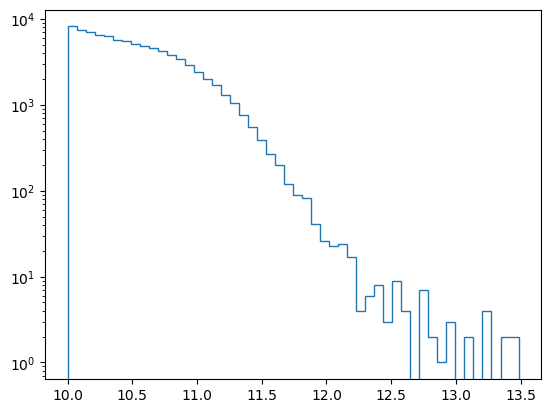

In [7]:
logm = catalog["logm"]
mask_mass = logm > 10
masked_logm = logm[mask_mass]
plt.hist(masked_logm, histtype = "step", bins = 50)
plt.yscale("log")

In [8]:
zphot = catalog["zphot"]
zphot

array([1.593 , 0.1151,    nan, ...,    nan,    nan,    nan])

In [9]:
#Para valores z>2

lista_de_arrays = [np.array(zphot)]
resultados = [array[array > 2] for array in lista_de_arrays]

print(resultados)

#Imprimir la lista completa
#print("Lista completa:")
#for array in resultados:
 #   for elemento in array:
  #      print(elemento, end=' ')

[array([2.8698, 2.8235, 4.775 , ..., 4.2732, 2.6115, 7.6066])]


In [10]:
#Zlow
zlo = catalog["zlo"]
zlo

array([1.514 , 0.0234,    nan, ..., 1.4051, 2.3782, 1.4486])

In [11]:
#Zhi
zhi = catalog["zhi"]
zhi

array([1.6732, 0.4184,    nan, ..., 1.9242, 2.9061, 3.9265])

# Graficos

In [12]:
ra2 = ra[(zphot > 2) & (zphot < 2.1)]
dec2 = dec[(zphot > 2) & (zphot < 2.1)]
z2 = zphot[(zphot > 2) & (zphot < 2.1)]
lower_z = catalog["zlo"][(zphot > 2) & (zphot < 2.1)]
higher_z = catalog["zhi"][(zphot > 2) & (zphot < 2.1)]

Text(0.5, 1.0, 'Distribución de objetos en el plano RA-DEC')

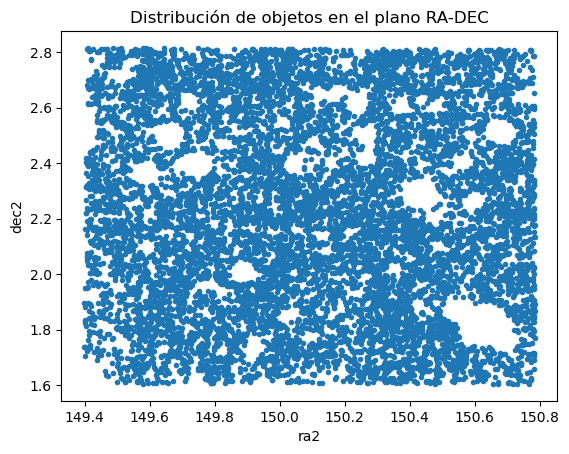

In [13]:
# Datos 
x = np.array(ra2)
y = np.array(dec2)

fig, ax = plt.subplots()
ax.scatter(x, y, marker = ".")

plt.xlabel('ra2')
plt.ylabel('dec2')
plt.title('Distribución de objetos en el plano RA-DEC')

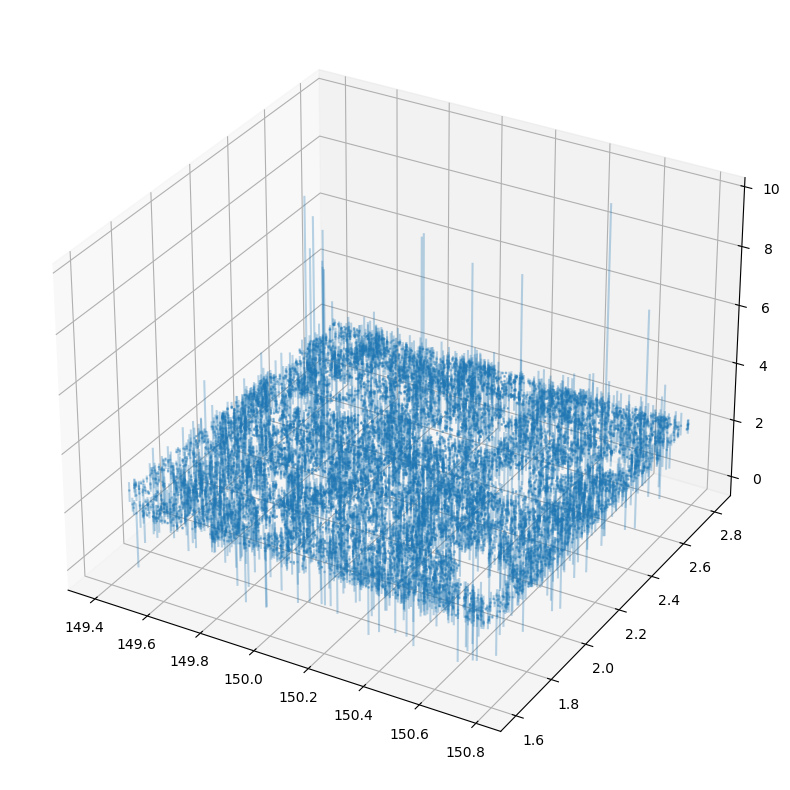

In [14]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection = "3d")
ax.errorbar(ra2,dec2,z2, zerr = np.stack((z2 - lower_z, higher_z - z2)), fmt = "None", alpha = 0.3)
ax.scatter(ra2,dec2,z2, s = 1, alpha = 0.3)

### Histograma eje X

Text(0.5, 1.0, 'X-axis histogram')

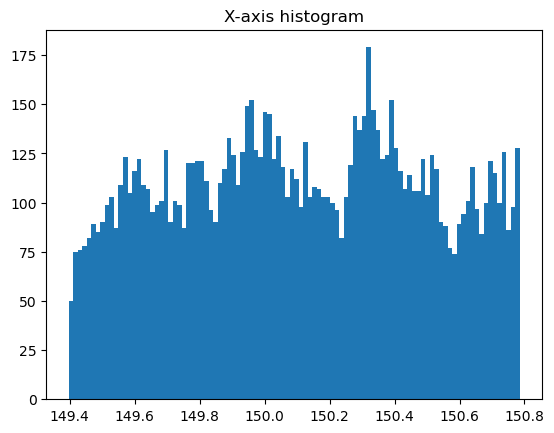

In [15]:
plt.hist(x, bins = 100);
plt.title("X-axis histogram")

### Histograma eje Y

Text(0.5, 1.0, 'Y-axis histogram')

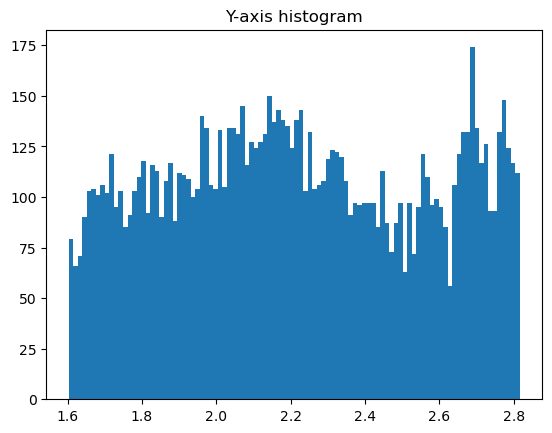

In [16]:
plt.hist(y, bins = 100);
plt.title("Y-axis histogram")

### Mapa de Densidad 
Juntando los graficos de histograma en el eje x e y, para que quede "grillado"

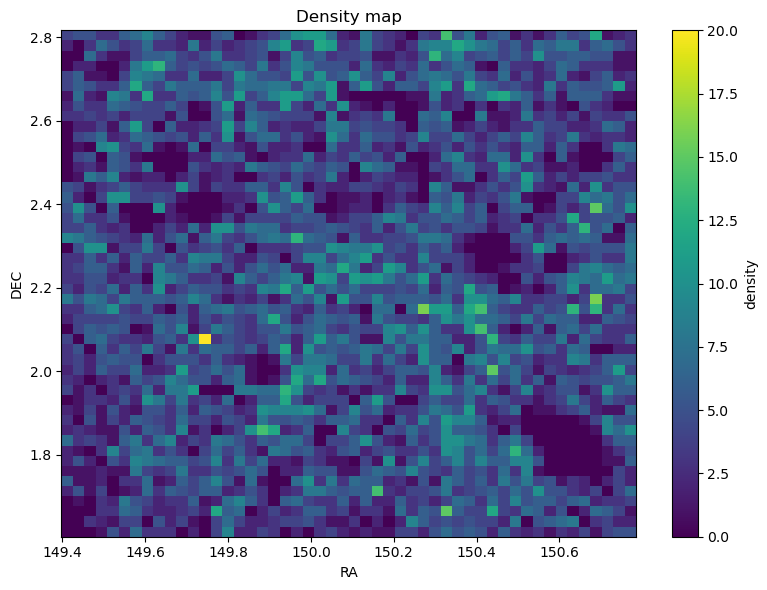

In [17]:
import matplotlib as mpl
from matplotlib import cm

fig = plt.figure(figsize = (8,6))
hist = np.histogram2d(x,y,bins = 50)
c = hist[0].flatten()
color = cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(c))
hist = plt.hist2d(x,y,bins = 50, cmap = color, norm = norm);
plt.colorbar(label = "density")
plt.xlabel("RA")
plt.ylabel("DEC")
plt.title("Density map")
fig.tight_layout()

### Distancia de las galaxias, tamañol pixel 0.005

In [18]:
catalog = readsav('cosmos2020_farmer_phot.sav')
zphot = catalog["zphot"]
zhi, zlo = catalog["zhi"], catalog["zlo"]
ra, dec = catalog["ra"], catalog["dec"], 
logm = catalog["logm"]
logmlo, logmhi = catalog["logmlo"], catalog["logmhi"]

In [19]:
mask_logm = logm > 10
zphot = zphot[mask_logm]
zhi, zlo = zhi[mask_logm], zlo[mask_logm]
logm = logm[mask_logm]
logmhi, logmlo = logmhi[mask_logm], logmlo[mask_logm]
ra, dec = ra[mask_logm], dec[mask_logm]

mask_redshift = zphot > 2
zphot = zphot[mask_redshift]
zhi, zlo = zhi[mask_redshift], zlo[mask_redshift]
logm = logm[mask_redshift]
logmhi, logmlo = logmhi[mask_redshift], logmlo[mask_redshift]
ra, dec = ra[mask_redshift], dec[mask_redshift]

In [39]:
from tqdm import tqdm
import sys
from astropy.coordinates import SkyCoord
from astropy import units as u

ra_min, ra_max = min(ra), max(ra)
dec_min, dec_max = min(dec), max(dec)
pixel_size = 0.005

ra_centers = np.arange(ra_min + 2*pixel_size, ra_max - 2*pixel_size, pixel_size)
dec_centers = np.arange(dec_min + 2*pixel_size, dec_max - 2*pixel_size, pixel_size)


distances = np.zeros((len(ra_centers), len(dec_centers)))
rho = np.zeros((len(ra_centers), len(dec_centers)))
N = 0
N_max_iter = 100

zmin, zmax = 2.0, 3 

for i in tqdm(range(len(ra_centers)), desc = "Calculando densidad..."):
    for j in range(len(dec_centers)):
        dists = []
        pixs = pixel_size
        nslices = 0
        N = 0
        while True:
            sys.stdout.write("\rpixell size = %.5f, N = %.i" % (pixs, len(dists)))
            sys.stdout.flush()
            mask = np.where((ra <= ra_centers[i] + pixs/2) & (ra >= ra_centers[i] - pixs/2) 
                          & (dec <= dec_centers[j] + pixs/2) & (dec >= dec_centers[j] - pixs/2)
                          & (zphot >= zmin) & (zphot <= zmax))
            center = centers = SkyCoord(ra_centers[i], dec_centers[j], unit = "deg")
            ras,decs = np.array(ra)[mask],np.array(dec)[mask]
            coords = SkyCoord(ras,decs, unit = "deg")
            dists = coords.separation(center)
            dists = dists.to(u.deg).value
            dists.sort()   
            if len(dists) > 5:
                distances[i, j] = dists[4]
                rho[(i-nslices):(i+nslices),(j-nslices):(j+nslices)] = 5/(4 * np.pi * dists[4]**2)
                break
            else:
                pixs += pixel_size
                nslices+=1
                continue                
        
print(f" Densidad promedio por pixel \033[91m{N / (len(ra_centers)*len(dec_centers))} \033[0m gax/pix")

ax = plt.axes()
plt.imshow(distances, extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', cmap='viridis')
plt.colorbar(label='Distancia promedio al centro del píxel')
ax.set(xlabel = "RA", ylabel = "DEC", title = 'Distancia de galaxias al centro de los píxeles')
plt.show()

Calculando densidad...:   0%|          | 0/274 [00:00<?, ?it/s]

pixell size = 0.02500, N = 5

Calculando densidad...:   0%|          | 1/274 [00:28<2:09:05, 28.37s/it]

pixell size = 0.02500, N = 5

Calculando densidad...:   1%|          | 2/274 [00:55<2:05:17, 27.64s/it]

pixell size = 0.02000, N = 4

Calculando densidad...:   1%|          | 3/274 [01:19<1:57:17, 25.97s/it]

pixell size = 0.02000, N = 3

Calculando densidad...:   1%|▏         | 4/274 [01:42<1:50:57, 24.66s/it]

pixell size = 0.02500, N = 4

Calculando densidad...:   2%|▏         | 5/274 [02:04<1:46:21, 23.72s/it]

pixell size = 0.02500, N = 5

Calculando densidad...:   2%|▏         | 6/274 [02:25<1:42:20, 22.91s/it]

pixell size = 0.02000, N = 4

Calculando densidad...:   3%|▎         | 7/274 [02:46<1:39:00, 22.25s/it]

pixell size = 0.02000, N = 4

Calculando densidad...:   3%|▎         | 8/274 [03:06<1:35:56, 21.64s/it]

pixell size = 0.02500, N = 5

Calculando densidad...:   3%|▎         | 9/274 [03:26<1:33:36, 21.19s/it]

pixell size = 0.03000, N = 5

Calculando densidad...:   4%|▎         | 10/274 [03:45<1:29:34, 20.36s/it]

pixell size = 0.02500, N = 5

Calculando densidad...:   4%|▍         | 11/274 [04:03<1:25:37, 19.53s/it]

pixell size = 0.01500, N = 2

Calculando densidad...:   4%|▍         | 12/274 [04:20<1:22:42, 18.94s/it]

pixell size = 0.01500, N = 3

Calculando densidad...:   5%|▍         | 13/274 [04:37<1:20:04, 18.41s/it]

pixell size = 0.01500, N = 3

Calculando densidad...:   5%|▌         | 14/274 [04:54<1:17:01, 17.77s/it]

pixell size = 0.02000, N = 5

Calculando densidad...:   5%|▌         | 15/274 [05:11<1:16:28, 17.71s/it]

pixell size = 0.01500, N = 3

Calculando densidad...:   6%|▌         | 16/274 [05:27<1:13:56, 17.20s/it]

pixell size = 0.01500, N = 5

Calculando densidad...:   6%|▌         | 17/274 [05:43<1:12:20, 16.89s/it]

pixell size = 0.02500, N = 5

Calculando densidad...:   7%|▋         | 18/274 [05:59<1:10:49, 16.60s/it]

pixell size = 0.03000, N = 5

Calculando densidad...:   7%|▋         | 19/274 [06:16<1:10:12, 16.52s/it]

pixell size = 0.03500, N = 5

Calculando densidad...:   7%|▋         | 20/274 [06:32<1:10:07, 16.56s/it]

pixell size = 0.03500, N = 2

Calculando densidad...:   8%|▊         | 21/274 [06:49<1:10:10, 16.64s/it]

pixell size = 0.04000, N = 4

Calculando densidad...:   8%|▊         | 22/274 [07:06<1:10:11, 16.71s/it]

pixell size = 0.03500, N = 3

Calculando densidad...:   8%|▊         | 23/274 [07:23<1:09:48, 16.69s/it]

pixell size = 0.03500, N = 3

Calculando densidad...:   9%|▉         | 24/274 [07:40<1:10:23, 16.89s/it]

pixell size = 0.04000, N = 5

Calculando densidad...:   9%|▉         | 25/274 [07:57<1:09:50, 16.83s/it]

pixell size = 0.03500, N = 3

Calculando densidad...:   9%|▉         | 26/274 [08:14<1:09:41, 16.86s/it]

pixell size = 0.04000, N = 5

Calculando densidad...:  10%|▉         | 27/274 [08:31<1:10:03, 17.02s/it]

pixell size = 0.03500, N = 4

Calculando densidad...:  10%|█         | 28/274 [08:48<1:09:53, 17.05s/it]

pixell size = 0.03500, N = 4

Calculando densidad...:  11%|█         | 29/274 [09:05<1:09:15, 16.96s/it]

pixell size = 0.03500, N = 5

Calculando densidad...:  11%|█         | 30/274 [09:22<1:08:46, 16.91s/it]

pixell size = 0.03000, N = 5

Calculando densidad...:  11%|█▏        | 31/274 [09:39<1:09:10, 17.08s/it]

pixell size = 0.03000, N = 4

Calculando densidad...:  12%|█▏        | 32/274 [09:56<1:08:39, 17.02s/it]

pixell size = 0.02500, N = 2

Calculando densidad...:  12%|█▏        | 33/274 [10:13<1:07:45, 16.87s/it]

pixell size = 0.03000, N = 5

Calculando densidad...:  12%|█▏        | 34/274 [10:30<1:07:31, 16.88s/it]

pixell size = 0.02500, N = 4

Calculando densidad...:  13%|█▎        | 35/274 [10:47<1:07:44, 17.01s/it]

pixell size = 0.02500, N = 4

Calculando densidad...:  13%|█▎        | 36/274 [11:05<1:08:43, 17.32s/it]

pixell size = 0.02500, N = 4

Calculando densidad...:  14%|█▎        | 37/274 [11:23<1:08:52, 17.44s/it]

pixell size = 0.03000, N = 5

Calculando densidad...:  14%|█▍        | 38/274 [11:40<1:08:43, 17.47s/it]

pixell size = 0.02500, N = 5

Calculando densidad...:  14%|█▍        | 39/274 [11:58<1:08:29, 17.49s/it]

pixell size = 0.02000, N = 3

Calculando densidad...:  15%|█▍        | 40/274 [12:16<1:08:42, 17.62s/it]

pixell size = 0.02000, N = 3

Calculando densidad...:  15%|█▍        | 41/274 [12:33<1:08:30, 17.64s/it]

pixell size = 0.02000, N = 4

Calculando densidad...:  15%|█▌        | 42/274 [12:51<1:08:50, 17.80s/it]

pixell size = 0.02000, N = 2

Calculando densidad...:  16%|█▌        | 43/274 [13:09<1:08:33, 17.81s/it]

pixell size = 0.02500, N = 5

Calculando densidad...:  16%|█▌        | 44/274 [13:27<1:08:13, 17.80s/it]

pixell size = 0.03000, N = 3

Calculando densidad...:  16%|█▋        | 45/274 [13:45<1:07:58, 17.81s/it]

pixell size = 0.03000, N = 3

Calculando densidad...:  17%|█▋        | 46/274 [14:03<1:07:38, 17.80s/it]

pixell size = 0.03000, N = 4

Calculando densidad...:  17%|█▋        | 47/274 [14:21<1:07:23, 17.81s/it]

pixell size = 0.03000, N = 4

Calculando densidad...:  18%|█▊        | 48/274 [14:39<1:07:45, 17.99s/it]

pixell size = 0.03000, N = 5

Calculando densidad...:  18%|█▊        | 49/274 [14:57<1:07:40, 18.05s/it]

pixell size = 0.03000, N = 5

Calculando densidad...:  18%|█▊        | 50/274 [15:15<1:07:02, 17.96s/it]

pixell size = 0.03000, N = 3

Calculando densidad...:  19%|█▊        | 51/274 [15:33<1:07:02, 18.04s/it]

pixell size = 0.03000, N = 5

Calculando densidad...:  19%|█▉        | 52/274 [15:52<1:07:42, 18.30s/it]

pixell size = 0.02500, N = 3

Calculando densidad...:  19%|█▉        | 53/274 [16:10<1:07:17, 18.27s/it]

pixell size = 0.02000, N = 3

Calculando densidad...:  20%|█▉        | 54/274 [16:28<1:06:48, 18.22s/it]

pixell size = 0.02000, N = 3

Calculando densidad...:  20%|██        | 55/274 [16:46<1:05:48, 18.03s/it]

pixell size = 0.02000, N = 2

Calculando densidad...:  20%|██        | 56/274 [17:03<1:04:45, 17.82s/it]

pixell size = 0.03000, N = 4

Calculando densidad...:  21%|██        | 57/274 [17:20<1:03:38, 17.60s/it]

pixell size = 0.04000, N = 4

Calculando densidad...:  21%|██        | 58/274 [17:38<1:03:14, 17.57s/it]

pixell size = 0.04000, N = 3

Calculando densidad...:  22%|██▏       | 59/274 [17:55<1:02:48, 17.53s/it]

pixell size = 0.05000, N = 5

Calculando densidad...:  22%|██▏       | 60/274 [18:13<1:02:57, 17.65s/it]

pixell size = 0.05500, N = 5

Calculando densidad...:  22%|██▏       | 61/274 [18:32<1:03:31, 17.89s/it]

pixell size = 0.05500, N = 5

Calculando densidad...:  23%|██▎       | 62/274 [18:50<1:03:46, 18.05s/it]

pixell size = 0.05500, N = 4

Calculando densidad...:  23%|██▎       | 63/274 [19:09<1:04:33, 18.36s/it]

pixell size = 0.05500, N = 5

Calculando densidad...:  23%|██▎       | 64/274 [19:28<1:04:54, 18.54s/it]

pixell size = 0.04500, N = 4

Calculando densidad...:  24%|██▎       | 65/274 [19:45<1:02:29, 17.94s/it]

pixell size = 0.04500, N = 5

Calculando densidad...:  24%|██▍       | 66/274 [20:02<1:01:55, 17.86s/it]

pixell size = 0.04500, N = 5

Calculando densidad...:  24%|██▍       | 67/274 [20:24<1:05:25, 18.96s/it]

pixell size = 0.04500, N = 5

Calculando densidad...:  25%|██▍       | 68/274 [20:44<1:05:55, 19.20s/it]

pixell size = 0.03500, N = 4

Calculando densidad...:  25%|██▌       | 69/274 [21:06<1:09:04, 20.22s/it]

pixell size = 0.04000, N = 5

Calculando densidad...:  26%|██▌       | 70/274 [21:31<1:13:43, 21.68s/it]

pixell size = 0.03500, N = 5

Calculando densidad...:  26%|██▌       | 71/274 [21:56<1:16:48, 22.70s/it]

pixell size = 0.03500, N = 5

Calculando densidad...:  26%|██▋       | 72/274 [22:21<1:18:26, 23.30s/it]

pixell size = 0.03500, N = 4

Calculando densidad...:  27%|██▋       | 73/274 [22:45<1:19:05, 23.61s/it]

pixell size = 0.04000, N = 5

Calculando densidad...:  27%|██▋       | 74/274 [23:10<1:19:21, 23.81s/it]

pixell size = 0.04500, N = 5

Calculando densidad...:  27%|██▋       | 75/274 [23:34<1:19:32, 23.98s/it]

pixell size = 0.04000, N = 5

Calculando densidad...:  28%|██▊       | 76/274 [23:58<1:18:47, 23.88s/it]

pixell size = 0.03500, N = 4

Calculando densidad...:  28%|██▊       | 77/274 [24:22<1:18:48, 24.00s/it]

pixell size = 0.03500, N = 5

Calculando densidad...:  28%|██▊       | 78/274 [24:46<1:18:18, 23.97s/it]

pixell size = 0.03000, N = 5

Calculando densidad...:  29%|██▉       | 79/274 [25:10<1:17:44, 23.92s/it]

pixell size = 0.02500, N = 3

Calculando densidad...:  29%|██▉       | 80/274 [25:33<1:16:33, 23.68s/it]

pixell size = 0.02000, N = 5

Calculando densidad...:  30%|██▉       | 81/274 [25:57<1:16:35, 23.81s/it]

pixell size = 0.02500, N = 5

Calculando densidad...:  30%|██▉       | 82/274 [26:21<1:16:24, 23.88s/it]

pixell size = 0.03000, N = 5

Calculando densidad...:  30%|███       | 83/274 [26:45<1:15:50, 23.83s/it]

pixell size = 0.04000, N = 5

Calculando densidad...:  31%|███       | 84/274 [27:07<1:14:27, 23.51s/it]

pixell size = 0.04000, N = 5

Calculando densidad...:  31%|███       | 85/274 [27:30<1:12:52, 23.14s/it]

pixell size = 0.02000, N = 5

Calculando densidad...:  43%|████▎     | 117/274 [55:34<13:13:40, 303.31s/it]

pixell size = 0.01500, N = 2

Calculando densidad...:  43%|████▎     | 118/274 [2:37:55<89:01:58, 2054.60s/it]

pixell size = 0.02500, N = 5

Calculando densidad...:  43%|████▎     | 119/274 [2:38:17<62:12:04, 1444.67s/it]

pixell size = 0.02000, N = 2

Calculando densidad...:  44%|████▍     | 120/274 [2:38:36<43:30:24, 1017.05s/it]

pixell size = 0.02500, N = 4

Calculando densidad...:  44%|████▍     | 121/274 [2:38:54<30:29:14, 717.35s/it] 

pixell size = 0.03000, N = 4

Calculando densidad...:  45%|████▍     | 122/274 [2:39:13<21:26:07, 507.68s/it]

pixell size = 0.03000, N = 5

Calculando densidad...:  45%|████▍     | 123/274 [2:39:31<15:08:10, 360.87s/it]

pixell size = 0.02500, N = 2

Calculando densidad...:  45%|████▌     | 124/274 [2:39:49<10:44:58, 257.99s/it]

pixell size = 0.02000, N = 2

Calculando densidad...:  46%|████▌     | 125/274 [2:40:06<7:41:40, 185.91s/it] 

pixell size = 0.01500, N = 2

Calculando densidad...:  46%|████▌     | 126/274 [2:40:26<5:35:07, 135.86s/it]

pixell size = 0.01500, N = 3

Calculando densidad...:  46%|████▋     | 127/274 [2:40:44<4:06:54, 100.78s/it]

pixell size = 0.01500, N = 2

Calculando densidad...:  47%|████▋     | 128/274 [2:41:03<3:05:10, 76.10s/it] 

pixell size = 0.02000, N = 2

Calculando densidad...:  47%|████▋     | 129/274 [2:41:22<2:22:16, 58.87s/it]

pixell size = 0.02500, N = 5

Calculando densidad...:  47%|████▋     | 130/274 [2:41:40<1:51:58, 46.66s/it]

pixell size = 0.02500, N = 3

Calculando densidad...:  48%|████▊     | 131/274 [2:41:58<1:30:43, 38.06s/it]

pixell size = 0.02500, N = 4

Calculando densidad...:  48%|████▊     | 132/274 [2:42:16<1:15:57, 32.10s/it]

pixell size = 0.02500, N = 5

Calculando densidad...:  49%|████▊     | 133/274 [2:42:34<1:05:10, 27.74s/it]

pixell size = 0.02500, N = 4

Calculando densidad...:  49%|████▉     | 134/274 [2:42:51<57:29, 24.64s/it]  

pixell size = 0.03000, N = 5

Calculando densidad...:  49%|████▉     | 135/274 [2:43:08<51:53, 22.40s/it]

pixell size = 0.03500, N = 5

Calculando densidad...:  50%|████▉     | 136/274 [2:43:25<47:47, 20.78s/it]

pixell size = 0.03500, N = 4

Calculando densidad...:  50%|█████     | 137/274 [2:43:42<44:38, 19.55s/it]

pixell size = 0.03500, N = 3

Calculando densidad...:  50%|█████     | 138/274 [2:43:58<42:09, 18.60s/it]

pixell size = 0.04000, N = 5

Calculando densidad...:  51%|█████     | 139/274 [2:44:15<40:40, 18.08s/it]

pixell size = 0.03500, N = 3

Calculando densidad...:  51%|█████     | 140/274 [2:44:32<39:24, 17.65s/it]

pixell size = 0.03500, N = 3

Calculando densidad...:  51%|█████▏    | 141/274 [2:44:49<38:40, 17.45s/it]

pixell size = 0.03000, N = 4

Calculando densidad...:  52%|█████▏    | 142/274 [2:45:06<38:17, 17.40s/it]

pixell size = 0.02000, N = 2

Calculando densidad...:  52%|█████▏    | 143/274 [2:45:23<37:49, 17.33s/it]

pixell size = 0.01000, N = 1

Calculando densidad...:  53%|█████▎    | 144/274 [2:45:40<37:16, 17.20s/it]

pixell size = 0.01000, N = 0

Calculando densidad...:  53%|█████▎    | 145/274 [2:45:57<36:45, 17.10s/it]

pixell size = 0.02000, N = 4

Calculando densidad...:  53%|█████▎    | 146/274 [2:46:14<36:22, 17.05s/it]

pixell size = 0.02500, N = 2

Calculando densidad...:  54%|█████▎    | 147/274 [2:46:31<36:07, 17.07s/it]

pixell size = 0.02000, N = 5

Calculando densidad...:  67%|██████▋   | 184/274 [2:57:32<26:33, 17.71s/it]

pixell size = 0.02000, N = 4

Calculando densidad...:  68%|██████▊   | 185/274 [2:57:50<26:24, 17.80s/it]

pixell size = 0.02500, N = 5

Calculando densidad...:  68%|██████▊   | 186/274 [2:58:09<26:34, 18.12s/it]

pixell size = 0.02500, N = 4

Calculando densidad...:  68%|██████▊   | 187/274 [2:58:25<25:08, 17.34s/it]

pixell size = 0.03500, N = 3

Calculando densidad...:  71%|███████   | 194/274 [3:00:10<19:28, 14.60s/it]

pixell size = 0.03000, N = 3

Calculando densidad...:  71%|███████   | 195/274 [3:00:24<18:48, 14.29s/it]

pixell size = 0.03000, N = 3

Calculando densidad...:  72%|███████▏  | 196/274 [3:00:37<18:05, 13.92s/it]

pixell size = 0.02000, N = 2

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



pixell size = 0.03000, N = 4

Calculando densidad...:  72%|███████▏  | 198/274 [3:01:03<17:14, 13.61s/it]

pixell size = 0.03000, N = 4

Calculando densidad...:  73%|███████▎  | 199/274 [3:01:17<17:05, 13.68s/it]

pixell size = 0.04500, N = 5

Calculando densidad...:  74%|███████▍  | 204/274 [3:02:34<17:55, 15.36s/it]

pixell size = 0.04000, N = 5

Calculando densidad...:  75%|███████▍  | 205/274 [3:02:53<18:55, 16.45s/it]

pixell size = 0.01500, N = 1

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



pixell size = 0.02000, N = 5

Calculando densidad...:  77%|███████▋  | 210/274 [3:03:50<11:41, 10.97s/it]

pixell size = 0.02500, N = 5

Calculando densidad...:  77%|███████▋  | 211/274 [3:03:58<10:41, 10.18s/it]

pixell size = 0.02500, N = 3

Calculando densidad...:  77%|███████▋  | 212/274 [3:04:06<09:52,  9.55s/it]

pixell size = 0.03000, N = 5

Calculando densidad...:  78%|███████▊  | 213/274 [3:04:14<09:11,  9.04s/it]

pixell size = 0.02500, N = 4

Calculando densidad...:  82%|████████▏ | 226/274 [3:05:59<06:33,  8.20s/it]

pixell size = 0.02500, N = 4

Calculando densidad...:  83%|████████▎ | 227/274 [3:06:07<06:28,  8.26s/it]

pixell size = 0.04500, N = 1

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



pixell size = 0.03500, N = 5

Calculando densidad...:  85%|████████▍ | 232/274 [3:06:53<06:28,  9.25s/it]

pixell size = 0.01500, N = 2

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



pixell size = 0.02000, N = 2

Calculando densidad...:  86%|████████▋ | 237/274 [3:07:45<06:14, 10.11s/it]

pixell size = 0.03000, N = 5

Calculando densidad...:  87%|████████▋ | 238/274 [3:07:55<06:03, 10.11s/it]

pixell size = 0.05000, N = 0

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



pixell size = 0.01000, N = 2

Calculando densidad...:  95%|█████████▍| 259/274 [3:11:38<02:30, 10.06s/it]

pixell size = 0.02000, N = 1

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



pixell size = 0.02500, N = 4

Calculando densidad...:  98%|█████████▊| 269/274 [3:12:48<00:32,  6.51s/it]

pixell size = 0.03500, N = 5

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



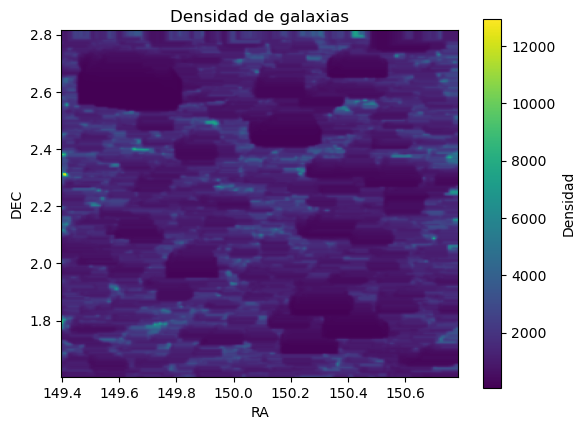

In [40]:
from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter
fig = plt.figure()
ax = plt.axes()
rho2 = gaussian_filter(rho, 0.75)
plt.imshow(rho2, extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', cmap='viridis')
plt.colorbar(label='Densidad')
ax.set(xlabel = "RA", ylabel = "DEC", title = 'Densidad de galaxias')
plt.show()